<a href="https://colab.research.google.com/github/aquapathos/MLLesson/blob/master/ML10%E9%A1%94%E8%AA%8D%E8%AD%98/FER2013Emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データセットFER2013による表情認識のニューラルネットワーク

顔画像データセットFER2013には人の６つの基本感情＋無表情、あわせて７つに分類された顔画像が集められています。

これを用いて顔による感情認識にチャレンジしてみます。



# エクマンの理論
![](https://i.imgur.com/lq7duPW.png)

エクマン（[Paul Ekman、1934年 - ](https://ja.wikipedia.org/wiki/%E3%83%9D%E3%83%BC%E3%83%AB%E3%83%BB%E3%82%A8%E3%82%AF%E3%83%9E%E3%83%B3)）の理論は、基本的な6つの感情（怒り・嫌悪・恐怖・幸福・悲しみ・驚き）は国・人種・文化にかかわらず、それぞれの感情を表す普遍的な表情があるという理論ですが、あくまでも基本であり、「軽蔑」「満足」「罪悪感」「安心」「羞恥」「喜び」などが加えられたり、国によっては異なる等の報告があったりします。

- [「日本人の表情がエクマンの理論とは異なることを実証 －世界で初めて日本人の基本6感情の表情を報告－」](https://www.kyoto-u.ac.jp/ja/research-news/2019-02-14-1)

### Google Drive をマウント
<img src=https://i.imgur.com/Axk82Oi.png width=300>

ドライブアイコンをクリックするか、下記コードを実行

```
from google.colab import drive
drive.mount('/content/drive')
```


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import os
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# kaggle API を実行できるようにする

FER2013のデータは Kaggle から入手するのが楽です。ダウンロードしてColabにアップロードするという手間が省けるからです。Kaggleに登録していない場合は登録して進めてください。

1.[ kaggle](https://www.kaggle.com/) の右上の自分のプロフィールアイコンをクリックし、ギアマーク（account）を開く
2. API欄の、Create New API Token をクリック    
<img src=https://i.imgur.com/eYEFFae.png width=300>
3. kaggle.json がダウンロードされるので、保存。




In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


# FER2013のデータセットをダウンロード

In [3]:
photos_dir = "/content/FACES/fer2013" # 画像保存用フォルダへのパス
%cd /content
!if [ ! -e FACES ]; then mkdir FACES ; fi
!if [ ! -e FACES/fer2013 ]; then mkdir FACES/fer2013 ; fi
%cd FACES/fer2013
!if [ ! -e fer2013.zip ]; then kaggle datasets download -d msambare/fer2013; fi
!if [ ! -e train ]; then unzip -q fer2013.zip; fi
!ls -l train
!ls -l test

/content
/content/FACES/fer2013
total 1340
drwxr-xr-x 2 root root 196608 Dec 22 04:14 angry
drwxr-xr-x 2 root root  20480 Dec 22 04:14 disgust
drwxr-xr-x 2 root root 192512 Dec 22 04:14 fear
drwxr-xr-x 2 root root 319488 Dec 22 04:14 happy
drwxr-xr-x 2 root root 262144 Dec 22 04:14 neutral
drwxr-xr-x 2 root root 237568 Dec 22 04:14 sad
drwxr-xr-x 2 root root 143360 Dec 22 04:14 surprise
total 360
drwxr-xr-x 2 root root 45056 Dec 22 04:14 angry
drwxr-xr-x 2 root root  4096 Dec 22 04:14 disgust
drwxr-xr-x 2 root root 53248 Dec 22 04:14 fear
drwxr-xr-x 2 root root 90112 Dec 22 04:14 happy
drwxr-xr-x 2 root root 69632 Dec 22 04:14 neutral
drwxr-xr-x 2 root root 69632 Dec 22 04:14 sad
drwxr-xr-x 2 root root 36864 Dec 22 04:14 surprise


Google Driveにデータセットの画像を残したい場合は次のようにすればいい。
```
photos_dir = "/content/drive/MyDrive/FACES" # 画像保存用フォルダへのパス
%cd /content/drive/MyDrive
!if [ ! -e FACES ]; then mkdir FACES ; fi
!if [ ! -e FACES/fer2013 ]; then mkdir FACES/fer2013 ; fi
%cd FACES/fer2013
!if [ ! -e fer2013.zip ]; then kaggle datasets download -d msambare/fer2013; fi
!if [ ! -e train ]; then unzip -q fer2013.zip; fi
!ls -l train
!ls -l test
```
ただし、Google Driveはアクセスが遅く、下記のプログラムでは学習時にもドライブ上の画像ファイルからデータを読み込むのですごく時間がかかるので推奨しない。

**kaggle datasets download -d msambare/fer2013**     
でデータセットをダウンロードしている。

このコマンドはKaggleで、FER2013の…ボタンメニューを開き、**Copy API command** から取得できる。    
<img src=https://i.imgur.com/WkZ2kIX.png width=200>

# データの確認

In [4]:
import cv2
# 画像のサイズ
cv2.imread(photos_dir+"/test/angry/PrivateTest_10131363.jpg").shape

(48, 48, 3)

# torchvision.ImageFolder でデータセットを作る
<img src=https://i.imgur.com/5nlwdDJ.png width=150>

ここまでで、/content/FACES/fer2013 (または、/content/drive/MyDrive/FACES/fer2013というフォルダに、train, test というフォルダができ、その中にそれぞれ、angry,disgust,fear,happy,neutral,sad,surprise というカテゴリごとのフォルダがあり、各フォルダ内に画像が分類されている状態である。

このようになっていたら、torchvision.ImageFolder を使って簡単に pytorch用のデータセットを作ることができる。

In [5]:
transform = {
    'train': transforms.Compose([
        #transforms.Grayscale(num_output_channels=1), # グレイスケール化
        #transforms.RandomRotation(degrees=[0,10]), # 10度までの範囲でランダムに回転
        #transforms.RandomHorizontalFlip(), # 左右反転
        transforms.Resize((48,48)), # 48x48にリサイズ
        transforms.ToTensor() # テンソル化
        #transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) # -1～1の範囲の浮動小数点化
    ]),
    'test': transforms.Compose([
        #transforms.Grayscale(num_output_channels=1),
        transforms.Resize((48,48)),
        transforms.ToTensor(),
        #transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))  # -1～1の範囲の浮動小数点化
    ])
}

transformGray = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=1), # グレイスケール化
        transforms.Resize((48,48)), # 48x48にリサイズ
        transforms.ToTensor() # テンソル化
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=1), # グレイスケール化
        transforms.Resize((48,48)), # 48x48にリサイズ
        transforms.ToTensor()
    ])
}


# データセットの作成
train_dataset = torchvision.datasets.ImageFolder(root=photos_dir+'/train', transform=transform['train'])
test_dataset = torchvision.datasets.ImageFolder(root=photos_dir+'/test', transform=transform['test'])
train_datasetGray = torchvision.datasets.ImageFolder(root=photos_dir+'/train', transform=transformGray['train'])
test_datasetGray = torchvision.datasets.ImageFolder(root=photos_dir+'/test', transform=transformGray['test'])

# データローダの作成
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, shuffle=True)
train_loaderGray = torch.utils.data.DataLoader(train_datasetGray, batch_size=batch_size, shuffle=True)
test_loaderGray = torch.utils.data.DataLoader(test_datasetGray,batch_size=batch_size, shuffle=True)

この時点でデータセットのラベルの対応付けが .class_to_idx という属性の保存されている。

In [6]:
train_dataset.class_to_idx

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [7]:
# 日本語に書き換え
train_dataset.class_to_idx ={'怒り': 0,'嫌悪': 1,'恐怖': 2,'幸福': 3,'無表情': 4,'悲しみ': 5,'驚き': 6}
# 結局使わなかったのでやらなくてよい。

# データの確認

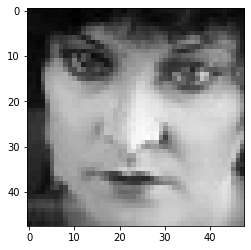

In [8]:
import matplotlib.pyplot as plt
Iter = iter(train_loader)
xdata, ydata = next(Iter)
plt.imshow(xdata[0,0],cmap="gray");

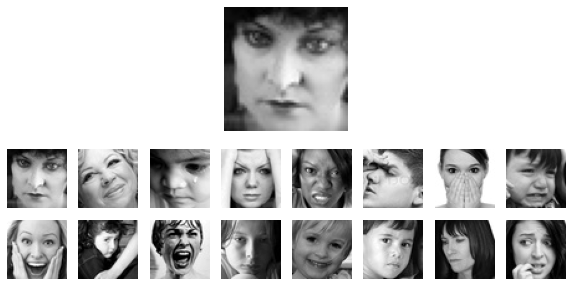

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.imshow(xdata[0,0],cmap="gray")
plt.axis('off')
for i in range(16):
  plt.subplot(4,8,i+17)
  plt.imshow(xdata[i,0],cmap="gray")
  plt.axis('off');

# MobilenetV2 と ResNet18 のモデルを使ってみる

それぞれ出力層以外のパラメータは学習済みの値で固定し、出力層が1000になっているので、７に置き換える。
転移学習としては出力層だけを書き換え、出力層のパラメータだけで学習する例が多いが、試したところあまりパフォーマンスはよくなく、構造だけ利用して０から学習してみたら良好な結果となった。

下のプログラムでは ResNet18では62層中のラスト10層、MobinenetV2ではラスト158層中のラスト30層以外は学習済みモデルのパラメータで固定して学習してみている。

In [10]:
# MobilenetV2
from torchvision.models import mobilenet_v2,MobileNet_V2_Weights
#mobnv2 = mobilenet_v2(pretrained=True).to(device)
mobnv2 = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V2).to(device)
params = []
for param in mobnv2.parameters(): # パラメータを固定
    params.append(param)
print("層数",len(params))
for param in params[:-30]: # ラスト30層までは固定
  param.requires_grad = False

# 最後の層だけを感情データの７出力に置き換える
mobnv2.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(1280, 7)).to(device)

層数 158


In [11]:
# Resnet18
import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights
resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).to(device)
params = []
for param in resnet.parameters(): # パラメータを固定
    params.append(param)
print("層数",len(params))
#resnet = resnet18(pretrained=True).to(device)メータを固定
#    param.requires_grad = False
#for param in resnet.parameters():  # 
for param in params[:-10]: # ラスト10層以外は固定
  param.requires_grad = False

# 最後の層だけを感情データの７出力に置き換える
resnet.fc = nn.Linear(512, 7).to(device)

層数 62


weights は以前は pretrained=True でデフォルト値が設定されたが pretrained は今後はサポートされなくなる。

In [ ]:
from torchsummary import summary
summary(resnet,(3,48,48))

In [ ]:
from torchsummary import summary
summary(mobnv2,(3,48,48))

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir logs

In [15]:
#@title　学習用ヘルパー関数
# 学習用ヘルパー関数
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir="./logs")

def train(model, dataloader, optimizer, epochs=1,lastepoch=0,label="loss"):
    model.train() # 学習モードにスイッチ
    for epoch in range(lastepoch,epochs,1):  # 全データをEPOCH回学習に利用したら終わり
        print(epoch,"/",epochs)
        running_loss = 0.0
        accuracy = 0
        total = 0
        nbatch = len(dataloader.dataset)//batch_size
        ndata = len(dataloader.dataset)
        # print(nbatch,ndata)
        for i, data in enumerate(dataloader, 0):
            # データセットからバッチサイズ個分のデータ[inputs, labels]を取り出す。
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            # すべての学習対象パラメータ（結合重み、しきい値）の微係数を０にセット
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(images) # 現モデルを使って出力を求める (forward)
            predicted = torch.max(model(images),1)[1]
            loss = nn.CrossEntropyLoss()(outputs, labels) #  # カテゴリカルクロスエントロピー誤差を計算
            loss.backward() # パラメータを変数として誤差を偏微分(backward)
            optimizer.step() # 誤差逆伝搬学習　誤差が減る方向にパラメータを修正 (optimize) 

            # 統計量の出力 epoch 毎に表示
            running_loss += loss.item()
            accuracy += (predicted == labels).sum().item() # 正解数を積算
            total += labels.size(0) # 入力画像数を積算
            #if i in[nbatch//4-1,nbatch//2-1,3*nbatch/4-1,nbatch-1]:
            if i%10 == 9 :
                writer.add_scalar(label+"loss", running_loss/total,epoch*ndata+total)
                writer.add_scalar(label+"acc", accuracy/total,epoch*ndata+total)
                #if i% 200 == 199:
                #  print(f'[{epoch + 1}] loss: {running_loss/total:.3f}  acc:{accuracy/total:.3f}  ({accuracy}/{total})')

        print(f'[{epoch + 1}] loss: {running_loss/total:.3f}  acc:{accuracy/total:.3f}  ({accuracy}/{total})')

    print('学習完了')

# 結果分析用ヘルパー関数
from pandas.compat.numpy import np_datetime64_compat
import pandas as pd
# クロス集計
def recognitionResult(model, dataloader, classes=[]):
    model.eval() # 推論モードにスイッチ
    ndata = 0 #
    NCAT = len(classes) 
    ct1 = np.zeros((NCAT,NCAT),np.uint16) # 認識結果集計表
    for data in dataloader:
      images, labels = data
      ndata += len(images)
      # バッチごとに出力を求める
      images = images.to(device)
      outputs = torch.max(model(images),1)[1]
      for i in range(len(labels)):
        ct1[labels[i],outputs[i]] += 1
    crossT1 = pd.concat([pd.DataFrame(classes,columns=['正解カテゴリ']),pd.DataFrame(ct1,columns=classes)],axis=1)
    crossT1 = pd.concat([crossT1,pd.DataFrame([np.nan if sum(ct1[i])==0 else np.round(1000*crossT1[cat][i]/np.sum(ct1[i]))/10 for i,cat in enumerate(classes)],columns=['正解率'])],axis=1).set_index('正解カテゴリ')
    
    ccount = 0
    for i in range(len(classes)):
      ccount += ct1[i,i]
    print(f"正解率は{np.round(1000*ccount/ct1.sum())/10}%")
    return crossT1
     

In [ ]:
%%time
optimizerR = optim.Adam(resnet.parameters(), lr=0.0003) # 
train(model=resnet, optimizer=optimizerR, dataloader=train_loader, epochs=20, lastepoch=0,label="resnet")

In [ ]:
%%time
optimizerM = optim.Adam(mobnv2.parameters(), lr=0.0003) # 
train(model=mobnv2, optimizer=optimizerM, dataloader=train_loader, epochs=20, lastepoch=0,label="mobilenet")

# 正解率
まず、訓練例での正解率

In [18]:
result = recognitionResult(resnet, train_loader, classes=['angry','disgust','fear','happy','neutral','sad','surprise'])
result

正解率は99.3%


,angry,disgust,fear,happy,neutral,sad,surprise,正解率
正解カテゴリ,,,,,,,,
angry,3949,2,6,18,4,12,4,98.8
disgust,0,435,0,0,0,0,1,99.8
fear,8,1,4050,12,4,11,11,98.9
happy,2,0,2,7207,3,1,0,99.9
neutral,8,0,5,22,4922,6,2,99.1
sad,8,2,15,9,3,4792,1,99.2
surprise,1,0,8,5,1,0,3156,99.5


テストデータでの正解率

In [19]:
result = recognitionResult(resnet, test_loader, classes=['angry','disgust','fear','happy','neutral','sad','surprise'])

正解率は46.9%


In [20]:
result

,angry,disgust,fear,happy,neutral,sad,surprise,正解率
正解カテゴリ,,,,,,,,
angry,339,4,125,211,112,129,38,35.4
disgust,12,54,11,15,4,13,2,48.6
fear,100,7,390,174,110,149,94,38.1
happy,93,6,125,1210,130,152,58,68.2
neutral,111,7,135,313,427,191,49,34.6
sad,132,16,163,312,164,425,35,34.1
surprise,33,6,92,86,59,36,519,62.5


嫌悪、恐怖、無表情、悲しみの正解率が低い。嫌悪が幸福と誤認識されている割合が多い。幸福が悲しみだという誤認識も多い。

In [21]:
result = recognitionResult(mobnv2, train_loader, classes=['angry','disgust','fear','happy','neutral','sad','surprise'])
result

正解率は98.8%


,angry,disgust,fear,happy,neutral,sad,surprise,正解率
正解カテゴリ,,,,,,,,
angry,3963,3,7,3,7,9,3,99.2
disgust,1,431,1,0,1,1,1,98.9
fear,20,1,4042,3,12,13,6,98.7
happy,23,1,9,7141,14,22,5,99.0
neutral,20,0,6,7,4918,10,4,99.1
sad,26,2,22,7,20,4751,2,98.4
surprise,11,0,32,5,5,1,3117,98.3


In [22]:
result = recognitionResult(mobnv2, test_loader, classes=['angry','disgust','fear','happy','neutral','sad','surprise'])
result

正解率は45.3%


,angry,disgust,fear,happy,neutral,sad,surprise,正解率
正解カテゴリ,,,,,,,,
angry,353,6,117,146,154,134,48,36.8
disgust,23,44,7,11,11,13,2,39.6
fear,169,2,383,119,139,143,69,37.4
happy,173,4,133,987,244,186,47,55.6
neutral,146,2,90,210,552,182,51,44.8
sad,178,9,169,180,256,426,29,34.2
surprise,52,2,102,70,68,30,507,61.0


訓練例ではresnet18の方が優れているが、テスト例では MobileNetV2の方が勝るという結果となった。

## 全階層を学習に使ってみる
全階層を学習に使うとな何倍もの時間がかかりそうだが、パラメータ数から予想されるほど時間はかからない。



In [23]:
# Resnet18
import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights
resnetW = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).to(device)
# 最後の層だけを感情データの７出力に置き換える
resnetW.fc = nn.Linear(512, 7).to(device)

# MobilenetV2
from torchvision.models import mobilenet_v2,MobileNet_V2_Weights
mobnv2W = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V2).to(device)
mobnv2W.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(1280, 7)).to(device)

### MobileNetV2

In [ ]:
%%time
optimizerMW = optim.Adam(mobnv2W.parameters(), lr=0.0003) # 
train(model=mobnv2W, optimizer=optimizerMW, dataloader=train_loader, epochs=20, lastepoch=0,label="mobileW")

### 訓練データ

In [25]:
result = recognitionResult(mobnv2W, train_loader, classes=['angry','disgust','fear','happy','neutral','sad','surprise'])
result

正解率は98.5%


,angry,disgust,fear,happy,neutral,sad,surprise,正解率
正解カテゴリ,,,,,,,,
angry,3912,3,23,14,9,25,9,97.9
disgust,4,425,1,2,1,0,3,97.5
fear,11,1,3994,12,5,52,22,97.5
happy,8,0,13,7163,14,11,6,99.3
neutral,19,0,8,11,4892,33,2,98.5
sad,24,1,18,16,33,4733,5,98.0
surprise,6,0,9,4,1,0,3151,99.4


### テストデータ

In [26]:
result = recognitionResult(mobnv2W, test_loader, classes=['angry','disgust','fear','happy','neutral','sad','surprise'])
result

正解率は58.8%


,angry,disgust,fear,happy,neutral,sad,surprise,正解率
正解カテゴリ,,,,,,,,
angry,436,12,115,103,105,152,35,45.5
disgust,22,56,11,6,7,7,2,50.5
fear,126,3,439,57,104,199,96,42.9
happy,70,3,43,1407,114,91,46,79.3
neutral,119,2,93,128,672,192,27,54.5
sad,146,5,146,113,227,576,34,46.2
surprise,27,0,68,36,38,30,632,76.1


## ResNet18

In [ ]:
%%time
optimizerSW = optim.Adam(resnetW.parameters(), lr=0.0003) # 
train(model=resnetW, optimizer=optimizerSW, dataloader=train_loader, epochs=20, lastepoch=0,label="resnetW")

### 訓練データ

In [28]:
result = recognitionResult(resnetW, train_loader, classes=['angry','disgust','fear','happy','neutral','sad','surprise'])
result

正解率は97.9%


,angry,disgust,fear,happy,neutral,sad,surprise,正解率
正解カテゴリ,,,,,,,,
angry,3903,0,28,12,12,16,24,97.7
disgust,1,433,1,0,0,0,1,99.3
fear,17,1,4001,5,12,11,50,97.7
happy,6,0,8,7135,18,24,24,98.9
neutral,25,0,30,18,4848,31,13,97.6
sad,29,0,119,1,17,4647,17,96.2
surprise,3,0,13,7,2,3,3143,99.1


### テストデータ

In [29]:
result = recognitionResult(resnetW, test_loader, classes=['angry','disgust','fear','happy','neutral','sad','surprise'])
result

正解率は62.5%


,angry,disgust,fear,happy,neutral,sad,surprise,正解率
正解カテゴリ,,,,,,,,
angry,499,16,115,63,99,119,47,52.1
disgust,21,62,9,5,4,6,4,55.9
fear,113,3,521,32,104,134,117,50.9
happy,46,2,41,1416,129,83,57,79.8
neutral,84,1,95,89,735,176,53,59.6
sad,141,11,200,65,204,575,51,46.1
surprise,15,1,52,42,20,24,677,81.5


### ResNetが優秀という結果となった。

# 独自のモデル
ResNet18は ResNetの中で一番階層数の少ないモデルであるが、ResNetは224x224、Mobilenetは最小で96x96というサイズのカラー画像を前提としたモデルである。また、カテゴリ数は1000。それに対してFER2013の画像は 48x48のモノクロ画像でカテゴリ数は７しかない。はっきりいって無駄に深すぎるので、ResNetを真似て階層数を減らしたモデルを定義してみる。

In [30]:
class FReLU(nn.Module):
    def __init__(self, in_c, k=3, s=1, p=1):
        super().__init__()
        self.f_conv = nn.Conv2d(in_c, in_c, kernel_size=k,stride=s, padding=p,groups=in_c)
        self.bn = nn.BatchNorm2d(in_c)

    def forward(self, x):
        tx = self.bn(self.f_conv(x))
        out = torch.max(x,tx)
        return out

class motionnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,64, 3,padding=1, padding_mode='replicate') 
        self.frelu1 = FReLU(64)
        self.conv2 = nn.Conv2d(64,64,3, padding=1,padding_mode='replicate')
        self.frelu2 = FReLU(64)
        self.scut1 = nn.Conv2d(1, 64, 1,padding=0)
        self.pool1 = nn.MaxPool2d(2)

        self.conv3  = nn.Conv2d(64, 128, 3, padding=1,padding_mode='replicate')
        self.frelu3 = FReLU(128)
        self.conv4  = nn.Conv2d(128, 128, 3,padding=1, padding_mode='replicate')  
        self.frelu4 = FReLU(128)
        self.scut2 = nn.Conv2d(64, 128, 1,padding=0)
        self.pool2 = nn.MaxPool2d(2)

        self.conv5  = nn.Conv2d(128, 256, 3, padding=1,padding_mode='replicate')
        self.frelu5 = FReLU(256)
        self.conv6  = nn.Conv2d(256, 256, 3,padding=1, padding_mode='replicate')  
        self.frelu6 = FReLU(256)
        self.scut3 = nn.Conv2d(128, 256, 1,padding=0)

        self.pool3 = nn.MaxPool2d(2)
        self.conv7  = nn.Conv2d(256, 512, 3,padding=1, padding_mode='replicate')  
        self.frelu7 = FReLU(512)        
        self.gavg = nn.AvgPool2d(6) # グローバルアベレージプーリング 
        self.layer = nn.Linear(512, 7) 

    def forward(self, x0):

        x = self.conv1(x0) # 1ch -> 64  3x3フィルタで畳み込み 48x48->48x48
        x = self.frelu1(x)
        x = self.conv2(x) # 64ch -> 64  3x3フィルタで畳み込み 48x48 ->48x48
        x0 = self.scut1(x0)
        x = self.frelu2(x + x0)
        x0 = self.pool1(x)  # max pooling  2x2  48x48->24x24

        x = self.conv3(x0) # 64ch -> 128 ch 3x3フィルタで畳み込み 24x24 -> 24x24
        x = self.frelu3(x) 
        x = self.conv4(x) # 128 ch -> 128 ch 3x3フィルタで畳み込み 24x24 -> 24x24
        x0 = self.scut2(x0)
        x = self.frelu4(x + x0)
        x0 = self.pool2(x)  # max pooling  2x2  24x24->12x12

        x = self.conv5(x0) # 128ch -> 256 ch 3x3フィルタで畳み込み 12x12 -> 12x12
        x = self.frelu5(x) 
        x = self.conv6(x) # 256 ch -> 256 ch 3x3フィルタで畳み込み 12x12 -> 12x12
        x0 = self.scut3(x0)
        x = self.frelu6(x + x0)
        x = self.pool3(x)  # max pooling  2x2  12x12->6x6

        x = self.conv7(x) # 256ch -> 512 ch 3x3フィルタで畳み込み 6x6 -> 6x6
        x = self.frelu7(x) 
        x = self.gavg(x)  # 512ノード
        x = x.view(-1,512)
        x = self.layer(x) # 512->7

        return x


In [31]:
from torchsummary import summary
mnet = motionnet().to(device)
summary(mnet,(1,48,48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]             640
            Conv2d-2           [-1, 64, 48, 48]             640
       BatchNorm2d-3           [-1, 64, 48, 48]             128
             FReLU-4           [-1, 64, 48, 48]               0
            Conv2d-5           [-1, 64, 48, 48]          36,928
            Conv2d-6           [-1, 64, 48, 48]             128
            Conv2d-7           [-1, 64, 48, 48]             640
       BatchNorm2d-8           [-1, 64, 48, 48]             128
             FReLU-9           [-1, 64, 48, 48]               0
        MaxPool2d-10           [-1, 64, 24, 24]               0
           Conv2d-11          [-1, 128, 24, 24]          73,856
           Conv2d-12          [-1, 128, 24, 24]           1,280
      BatchNorm2d-13          [-1, 128, 24, 24]             256
            FReLU-14          [-1, 128,

In [ ]:
%%time
optimizer= optim.Adam(mnet.parameters(), lr=0.0003) # 
train(model=mnet, optimizer=optimizer, dataloader=train_loaderGray, epochs=20, lastepoch=0,label="resnetW")

In [33]:
result = recognitionResult(mnet, train_loaderGray, classes=['angry','disgust','fear','happy','neutral','sad','surprise'])
result

正解率は92.3%


,angry,disgust,fear,happy,neutral,sad,surprise,正解率
正解カテゴリ,,,,,,,,
angry,3774,1,101,0,12,106,1,94.5
disgust,2,425,9,0,0,0,0,97.5
fear,4,1,4075,0,2,13,2,99.5
happy,23,1,147,6776,93,175,0,93.9
neutral,5,0,65,1,4767,127,0,96.0
sad,7,0,35,0,1,4787,0,99.1
surprise,25,1,1203,4,14,37,1887,59.5


In [34]:
result = recognitionResult(mnet, test_loaderGray, classes=['angry','disgust','fear','happy','neutral','sad','surprise'])
result

正解率は55.2%


,angry,disgust,fear,happy,neutral,sad,surprise,正解率
正解カテゴリ,,,,,,,,
angry,410,3,224,14,67,239,1,42.8
disgust,20,53,17,1,6,14,0,47.7
fear,74,3,636,13,51,234,13,62.1
happy,53,2,164,1216,140,187,12,68.5
neutral,70,2,170,36,589,364,2,47.8
sad,75,1,262,27,138,744,0,59.7
surprise,29,0,395,22,24,49,312,37.5


# 実画像でのテスト
DeepFace の顔検出機能を使って顔を切り出した上で感情判定してみよう。

In [38]:
!pip -q install deepface
!pip -q install python-opencv-utils

In [39]:
from deepface.detectors import FaceDetector, OpenCvWrapper, SsdWrapper, DlibWrapper, MtcnnWrapper, RetinaFaceWrapper,MediapipeWrapper
from PIL import Image
import math
import numpy as np
from deepface.commons import distance
import cv2u

backends = [
  'opencv', 
  'ssd', 
  'dlib', 
  'mtcnn', 
  'retinaface', 
  #'mediapipe'
]

pic = cv2u.urlread("https://nogizaka46family.com/wp-content/uploads/2020/04/nogizaka46_11.jpg")
h = pic.shape[0]//2
w = pic.shape[1]//2
pic = cv2.resize(pic,(w,h))

for d in backends:
  detector = FaceDetector.build_model(d) #opencv, ssd, dlib, mtcnn or retinaface
  obj = FaceDetector.detect_faces(detector, d, pic)
  print(f" {d} が 検出した顔は {len(obj)}個")

 opencv が 検出した顔は 5個
 ssd が 検出した顔は 4個
 dlib が 検出した顔は 11個
3/3 [==============================] - 0s 25ms/step
 mtcnn が 検出した顔は 12個
 retinaface が 検出した顔は 12個


DeepFace の facedetect はパラメータを指定できない。（唯一、align=True/Falseが指定できるのみ）。Dlib モジュールは 内部的には dlib.get_frontal_face_detector()を呼び出している。dlib.get_frontal_face_detector()は detect時にアップサンプリングするパラメータがあるのだが、DeepFaceからの呼び出しではアップサンプリング=1が埋め込まれている。

デフォルト設定でなるべくたくさんの顔を認識させたいならmtcnn か retinaface を使うのが吉

In [40]:
obj[0][1]

[642, 196, 92, 90]

3/3 [==============================] - 0s 5ms/step


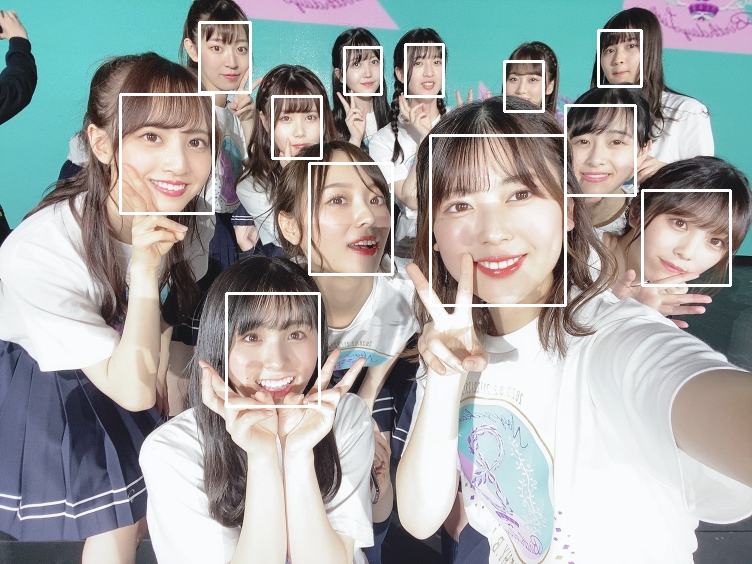

In [41]:
detector = FaceDetector.build_model('mtcnn') #opencv, ssd, dlib, mtcnn or retinaface
obj = FaceDetector.detect_faces(detector, 'mtcnn', pic)
dimg = pic.copy()
for i in range(len(obj)):
  x,y,w,h = obj[i][1]
  dimg = cv2.rectangle(dimg,(x,y),(x+w,y+h),(255,255,255),2)
Image.fromarray(dimg[:,:,::-1])

In [42]:
!pip -q install japanize-matplotlib

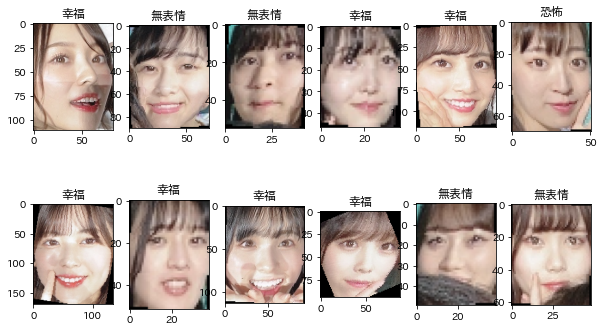

In [43]:
import japanize_matplotlib
e7 = ['怒り','嫌悪','恐怖','幸福','無表情','悲しみ','驚き']
transform = transformGray['test']
faces = torch.stack([transform(Image.fromarray(img[:,:,::-1])) for (img,_) in obj])
emotions = mnet(faces.to(device))
emotions = torch.max(emotions,1)[1]
plt.figure(figsize=(10,6))
for i,(img,rect) in enumerate(obj):
    plt.subplot(2,len(obj)//2,i+1)
    plt.imshow(img[:,:,::-1])
    plt.title(e7[emotions[i]])

つぎはretainfaceでやってみよう。

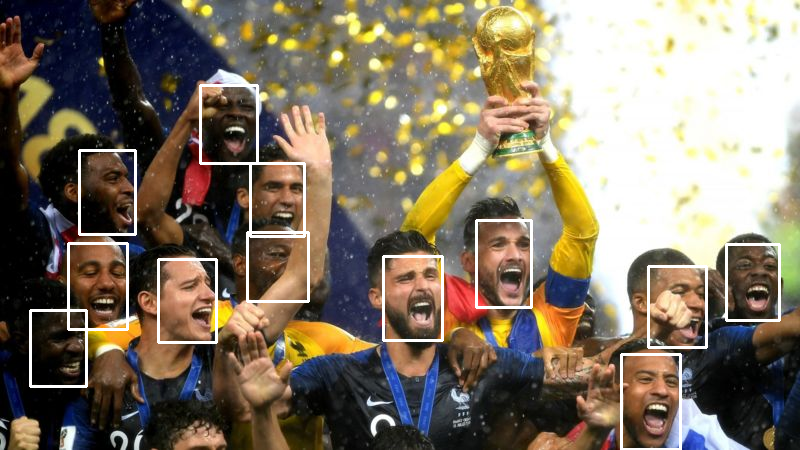

In [44]:
pic = cv2u.urlread("https://ichef.bbci.co.uk/news/800/cpsprodpb/2321/production/_102539980_lloris.jpg")
detector = FaceDetector.build_model('retinaface') #opencv, ssd, dlib, mtcnn or retinaface
obj = FaceDetector.detect_faces(detector, 'retinaface', pic)
dimg = pic.copy()
for i in range(len(obj)):
  x,y,w,h = obj[i][1]
  dimg = cv2.rectangle(dimg,(x,y),(x+w,y+h),(255,255,255),2)
Image.fromarray(dimg[:,:,::-1])

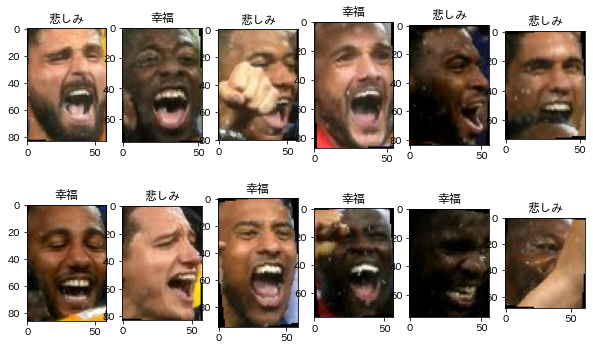

In [45]:
transform = transformGray['test']
faces = torch.stack([transform(Image.fromarray(img[:,:,::-1])) for (img,_) in obj])
emotions = mnet(faces.to(device))
emotions = torch.max(emotions,1)[1]
plt.figure(figsize=(10,6))
for i,(img,rect) in enumerate(obj):
    plt.subplot(2,len(obj)//2,i+1)
    plt.imshow(img[:,:,::-1])
    plt.title(e7[emotions[i]])

幸せな時、感動したときにも人は泣きますが、悲しみと幸福は紙一重というところでしょうか。

# Embedding

DeepFace には 顔画像から、その画像のもつ特徴を集約表現したEmbeddingsと呼ばれる特徴ベクトルを算出する関数があります。

<image src=https://cdn-ak.f.st-hatena.com/images/fotolife/o/optim-tech/20210930/20210930131332.jpg width=500>

（https://tech-blog.optim.co.jp/entry/2021/10/01/100000より引用）

転移学習では一般に全結合層の手前までを固定しますが、その固定された部分の出力が Embeddingです。
1000カテゴリもの識別問題に対応できる Embedding には、汎用的に使える画像特徴が含まれていると予想でき、実際様々な応用に利用できることが経験的にわかっています。

今回の実験で利用したMobileNetV2とResNet18では、全結合層だけのファインチューニングではあまりよい結果は出なかったので、それらから得られる Embeddingはこの問題には有効ではないだろうと予想できますが、DeepFaceのEmbeddingは試してみる価値があるでしょう。

利用できるならば、畳み込み層はなしで、Embeddingを入力とする全結合のニューラルネットワークで学習させることになります。

長くなってきたので、それはまた別のノートにしたいと思います。

